In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

Hyper parameters

In [3]:
WINDOW_SIZE=10
BATCH_SIZE=32

股票資料使用從2025-02-14到2025-05-16共62天(但實際只有61天,因為每天的明天要作為當天的ground truth,所以最後一天20250516刪除只做為0517的label)

In [4]:
# 讀取股票資料
stock_data = pd.read_csv('./tmp/stock_data_1.csv', dtype={"stock_code": str, "date": str})
stock_data.set_index(["stock_code", "date"], inplace=True)
stock_data.sort_index(inplace=True)

訓練輸入股票特徵選用6種並對其資料做Z-score標準化

In [5]:
stocks_data_frame = []
scaler = StandardScaler()

# 定義訓練資料集
all_stock_data = []
for stock_code in stock_data.index.get_level_values(0).unique():
    stock_df = pd.DataFrame({
        'open': stock_data.loc[stock_code]['open'],#開盤價
        'close': stock_data.loc[stock_code]['close'],#收盤價'
        'high': stock_data.loc[stock_code]['high'],#最高價
        'low': stock_data.loc[stock_code]['low'],#最低價
        'volume': stock_data.loc[stock_code]['transaction_volume'],#成交量
        'change': stock_data.loc[stock_code]['change'],#漲跌幅
    })
    all_stock_data.append(stock_df)

# 將所有股票資料合併成一個大DataFrame
combined_df = pd.concat(all_stock_data, ignore_index=True)

# 對所有股票的數值欄位進行Z-score標準化
numeric_columns = ['open', 'close', 'high', 'low', 'volume', 'change']
scaler.fit(combined_df[numeric_columns])

# 將標準化後的資料分回各個股票
for df in all_stock_data:
    df[numeric_columns] = scaler.transform(df[numeric_columns])
    stocks_data_frame.append(df)
print(stocks_data_frame)
# 儲存scaler供之後使用
import joblib
joblib.dump(scaler, './model/scaler.pkl')
    
    


[              open     close      high       low    volume    change
date                                                                
20250214  0.628325  0.625480  0.610558  0.640173  9.954095 -0.265600
20250217  0.626126  0.641749  0.620274  0.647184  2.800092  0.415807
20250218  0.643445  0.645610  0.625402  0.657560  2.359089  0.126530
20250219  0.642070  0.643679  0.625402  0.659804  3.086981 -0.008465
20250220  0.638222  0.639543  0.620274  0.649147  4.929681 -0.059892
...            ...       ...       ...       ...       ...       ...
20250512  0.520285  0.530072  0.512585  0.539214  3.334749  0.287239
20250513  0.549701  0.541929  0.534716  0.558004  3.484566  0.312953
20250514  0.555199  0.564264  0.544433  0.572026  3.730259  0.557231
20250515  0.560972  0.562058  0.544433  0.575672  3.469895 -0.014894
20250516  0.557398  0.564816  0.546052  0.573989  2.027151  0.100817

[62 rows x 6 columns],               open     close      high       low    volume    change
date     

['./model/scaler.pkl']

刪除那些在這段期間沒有全部有資料(也就是不足62天)的股票=>所剩1574檔股票

In [6]:
# 檢查並刪除不符合(62,6)大小的資料框
abnormal_stocks = []
for i in range(len(stocks_data_frame)):
    if stocks_data_frame[i].shape != (62, 6):
        abnormal_stocks.append(i)

#將原本資料刪除這些不完整的股票
stocks_data_frame = [df for i, df in enumerate(stocks_data_frame) if i not in abnormal_stocks]

print(f"刪除後剩餘股票數量: {len(stocks_data_frame)}")

刪除後剩餘股票數量: 1574


將所有股票資料同一天的concat到同一row=>shape=(天數,股票數量*特徵數)

使模型能夠學習不同股票間的關連性

替剩餘每支股票建立一個整數ID供之後模型embedding輸入

In [182]:
# # 從list中取得所有不重複的股票代碼
# ids = []
# for df in stocks_data_frame:
#     code = df['stock_code'].iloc[0]#取得資料中所有stock code
#     if code not in ids:
#         ids.append(code)
# stock_code_to_id = {code: idx for idx, code in enumerate(ids)}#建立一個映射表

In [ ]:
# print(stock_code_to_id)

In [177]:
# # 刪除 stock_code 欄位
# for df in stocks_data_frame:
#     df.drop('stock_code', axis=1, inplace=True)

In [118]:
# #將剩餘股票中的股票代碼用獨立整數id替代
# for df in stocks_data_frame:
#     df['stock_code'] = df['stock_code'].map(stock_code_to_id)

將每支股票資料往前移一天作為label供訓練,並只取change作訓練

In [7]:
#將所有股票往前一天移動來產生預測label
#因為最後只要預測漲跌幅,所有change_labels只儲存labels中change的col
labels = []
shifted_labels=[]
shifted_stocks = []

for stock_df in stocks_data_frame:
    # 產生label
    labels = stock_df.shift(-1)
    labels = labels.iloc[:-1]  # 刪除最後一天(NaN)
    
    # 只取每5個column的change作為label
    change_cols = [col for col in labels.columns if 'change' in col]
    labels = labels[change_cols]
    shifted_labels.append(labels)
    
    # 刪除最後一天資料與label統一
    new_df = stock_df.iloc[:-1]
    shifted_stocks.append(new_df)



In [9]:
print(shifted_stocks[-1]['change'])

date
20250214    0.679370
20250217    0.229384
20250218   -0.220602
20250219    0.615086
20250220    0.615086
              ...   
20250509    0.036533
20250512   -0.027751
20250513    0.100817
20250514   -0.220602
20250515    0.165100
Name: change, Length: 61, dtype: float64


In [10]:
shifted_labels[-1]

,change
date,
20250214,0.229384
20250217,-0.220602
20250218,0.615086
20250219,0.615086
20250220,-0.156318
...,...
20250509,-0.027751
20250512,0.100817
20250513,-0.220602


使用sliding windows來處理data,設定window size=10(因input資料只有61天)

In [11]:
def create_seq_data(stocks,labels,seq_size):
    seq=[]#裝每支股票經過windows切分過後的資料
    seq_label=[]#裝每支股票中每個window的label

    for stock,label in zip(stocks,labels):
        for i in range(len(stock)-seq_size+1):
            seq.append(stock.iloc[i:i+seq_size])
            seq_label.append(label.iloc[i+seq_size-1])

    return np.array(seq), np.array(seq_label)

用每10天作為一筆資料並預測第11天的change來將61天的資料切分data和Label為時間序列模型可輸入的資料

In [134]:
x,y=create_seq_data(shifted_stocks,shifted_labels,WINDOW_SIZE)

x(Data) shape:(每支股票切分後的window數*有幾檔股票,window size,特徵數)

y(Label) shape:(每支股票切分後的window數*有幾檔股票)

In [196]:
print(x.shape)
print(y.shape)

[[ 6.28324842e-01  6.25480054e-01  6.10557875e-01  6.40173014e-01
   9.95409480e+00 -2.65600173e-01]
 [ 6.26125566e-01  6.41749127e-01  6.20274242e-01  6.47184033e-01
   2.80009216e+00  4.15806813e-01]
 [ 6.43444866e-01  6.45609585e-01  6.25402325e-01  6.57560340e-01
   2.35908895e+00  1.26530262e-01]
 [ 6.42070319e-01  6.43679356e-01  6.25402325e-01  6.59803866e-01
   3.08698135e+00 -8.46546152e-03]
 [ 6.38221585e-01  6.39543151e-01  6.20274242e-01  6.49147118e-01
   4.92968124e+00 -5.98924039e-02]
 [ 6.35747399e-01  6.47264066e-01  6.25672224e-01  6.53634170e-01
   2.07427438e+00  2.16527411e-01]
 [ 6.33823033e-01  6.37612922e-01  6.17305353e-01  6.51390644e-01
   5.22620255e+00 -1.88459760e-01]
 [ 6.15953913e-01  6.29340512e-01  6.08128784e-01  6.31198911e-01
   5.22457250e+00  1.71528837e-01]
 [ 1.80601932e-03  3.39482737e-03 -4.27223987e-03  8.34003554e-03
  -2.70037023e-01  4.93898486e-02]
 [ 5.93411331e-01  5.92666161e-01  5.77360288e-01  6.02593956e-01
   2.43920597e+01 -5.3559

將以上資料切分成訓練集和測試集並準備Data Loader

In [184]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    x, 
    y,
    test_size=0.2,#驗證集佔20%
    shuffle=False  
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)



train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)



準備模型(使用Encoder-only 的Transformer)

In [185]:
class StockTransformer(nn.Module):
    def __init__(self,input_dim,d_model,nhead,num_layers,dropout):
        super().__init__()
        self.input_dim=input_dim
        self.d_model=d_model
        #將輸入維度轉為d_model
        self.feature_embedding = nn.Linear(input_dim, d_model)
        #加入positional encoding(用learnable para)
        self.positional_encoding=nn.Parameter(torch.rand(1,10,d_model))
        #Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        #輸出回歸層
        self.regressor = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, 1)
        )
    def forward(self,x):
        x=self.feature_embedding(x)
        x=x+self.positional_encoding
        encoded=self.encoder(x)
        last=encoded[:,-1,:]
        output=self.regressor(last)

        return output


In [186]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


建立模型以及設定參數

In [187]:
model = StockTransformer(input_dim=6,d_model=64,nhead=2,num_layers=2,dropout=0.1).to(device)

In [188]:
print(model)

StockTransformer(
  (feature_embedding): Linear(in_features=6, out_features=64, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (regressor): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


設定Loss function和optimizer


In [189]:
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [190]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device).float()   # (B, 10, 6)
        y_batch = y_batch.to(device).float()   # (B, 1)

        optimizer.zero_grad()
        preds = model(X_batch)                # shape: (B, 1)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device).float()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)


訓練並記錄訓練結果和儲存模型

In [191]:
EPOCHS = 20

train_losses=[]
val_losses = []

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = eval_epoch(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
#儲存模型
torch.save(model.state_dict(), "stock_transformer.pth")


Epoch 1/20 | Train Loss: 1.1730 | Val Loss: 0.6598
Epoch 2/20 | Train Loss: 1.1752 | Val Loss: 0.6502
Epoch 3/20 | Train Loss: 1.1654 | Val Loss: 0.6508
Epoch 4/20 | Train Loss: 1.1721 | Val Loss: 0.6500
Epoch 5/20 | Train Loss: 1.1719 | Val Loss: 0.6503
Epoch 6/20 | Train Loss: 1.1718 | Val Loss: 0.6500
Epoch 7/20 | Train Loss: 1.1718 | Val Loss: 0.6509
Epoch 8/20 | Train Loss: 1.1719 | Val Loss: 0.6499
Epoch 9/20 | Train Loss: 1.1719 | Val Loss: 0.6499
Epoch 10/20 | Train Loss: 1.1718 | Val Loss: 0.6509
Epoch 11/20 | Train Loss: 1.1718 | Val Loss: 0.6503
Epoch 12/20 | Train Loss: 1.1719 | Val Loss: 0.6502
Epoch 13/20 | Train Loss: 1.1718 | Val Loss: 0.6499
Epoch 14/20 | Train Loss: 1.1719 | Val Loss: 0.6509
Epoch 15/20 | Train Loss: 1.1722 | Val Loss: 0.6500
Epoch 16/20 | Train Loss: 1.1718 | Val Loss: 0.6508
Epoch 17/20 | Train Loss: 1.1721 | Val Loss: 0.6503
Epoch 18/20 | Train Loss: 1.1719 | Val Loss: 0.6500
Epoch 19/20 | Train Loss: 1.1719 | Val Loss: 0.6502
Epoch 20/20 | Train L

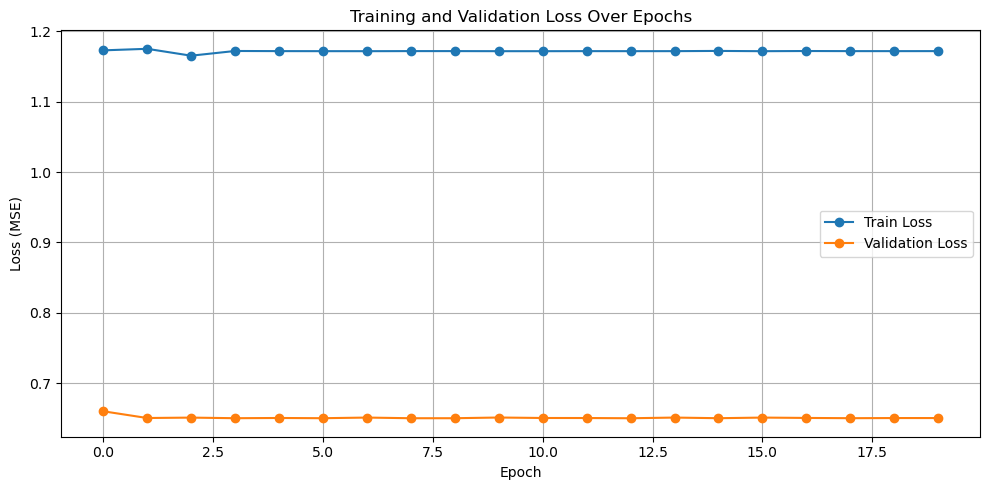

In [192]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Prediction

In [193]:
model = StockTransformer(input_dim=6,d_model=64 ,nhead=2,num_layers=2,dropout=0.1)
model.load_state_dict(torch.load("./stock_transformer.pth"))
model = model.to(device)  # 將模型移到GPU
model.eval()


StockTransformer(
  (feature_embedding): Linear(in_features=6, out_features=64, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (regressor): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [195]:
import random

# 隨機選擇多筆測試資料
num_samples = 5  # 要預測的樣本數
random_indices = random.sample(range(len(X_val)), num_samples)

x_test = X_val[random_indices]
y_test = y_val[random_indices]

x_input = torch.tensor(x_test).float()  # shape: (num_samples, 10, 6) 
x_input = x_input.to(device)  # 將輸入數據移到GPU

with torch.no_grad():
    predictions = model(x_input)
    
    for i in range(num_samples):
        print(f"\n樣本 {i+1}:")
        print(f"預測漲跌幅: {predictions[i].item():}")
        print(f"實際漲跌幅: {y_test[i].item():}")
        print("預測與實際漲跌趨勢是否相同:", 
              (predictions[i].item() > 0 and y_test[i].item() > 0) or 
              (predictions[i].item() < 0 and y_test[i].item() < 0))





樣本 1:
預測漲跌幅: 0.008040925487875938
實際漲跌幅: 0.18438556790351868
預測與實際漲跌趨勢是否相同: True

樣本 2:
預測漲跌幅: 0.008040925487875938
實際漲跌幅: -0.2848852872848511
預測與實際漲跌趨勢是否相同: False

樣本 3:
預測漲跌幅: 0.008040925487875938
實際漲跌幅: 0.036533113569021225
預測與實際漲跌趨勢是否相同: True

樣本 4:
預測漲跌幅: 0.008040925487875938
實際漲跌幅: 0.05196119472384453
預測與實際漲跌趨勢是否相同: True

樣本 5:
預測漲跌幅: 0.008040925487875938
實際漲跌幅: 0.04938985034823418
預測與實際漲跌趨勢是否相同: True


/tmp/ipykernel_333078/3144996874.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_input = torch.tensor(x_test).float()  # shape: (num_samples, 10, 6)


In [157]:
x_test

tensor([[[ 0.2426,  0.2477,  0.2346,  0.2476, -0.3164,  0.1008],
         [ 0.2399,  0.2477,  0.2346,  0.2532, -0.3409,  0.0365],
         [ 0.2454,  0.2505,  0.2373,  0.2560, -0.3403,  0.1008],
         [ 0.2481,  0.2394,  0.2373,  0.2476, -0.2966, -0.2206],
         [ 0.2371,  0.2394,  0.2319,  0.2476, -0.3178,  0.0365],
         [ 0.2316,  0.2256,  0.2211,  0.2335, -0.2299, -0.2849],
         [ 0.2261,  0.2312,  0.2238,  0.2363, -0.3099,  0.1651],
         [ 0.2316,  0.2339,  0.2238,  0.2419, -0.3262,  0.1008],
         [ 0.2344,  0.2394,  0.2265,  0.2448, -0.3385,  0.1651],
         [ 0.2371,  0.2422,  0.2292,  0.2448, -0.3099,  0.1008]],

        [[ 0.6138,  0.6696,  0.6637,  0.6205,  0.1673,  2.0293],
         [ 0.6742,  0.6255,  0.6610,  0.5785,  0.0252, -0.9920],
         [ 0.6028,  0.6861,  0.6826,  0.6233, -0.0771,  1.4508],
         [ 0.6385,  0.5979,  0.6232,  0.6065,  0.3832, -2.0205],
         [ 0.6220,  0.6034,  0.6044,  0.6149, -0.2568,  0.1651],
         [ 0.6000,  0.5